# **Mental Health in the Tech Industry**
**Problem** <br>
In 2022, The Burnout Index surveyed 32,644 IT professionals across 33 countries and found that 62% of IT professionals feel physically and emotionally drained due to the demands of their jobs. Poor mental health has a huge negative impact on employees' productivity and overall quality of life, both at professional and personal levels. <br>
*Sourse [European Recruitment](https://eu-recruit.com/mental-health-in-the-tech-industry/)*<br>
**Project goal** <br>
The main goal of this project is to analyse the Open Source Mental Illness survey results on Mental Health in the Tech Workplace. The surveys were conducted in 5 years in total, from 2014 to 2019. <br>
Main question the project seeks to answer:
- how many respondents suffer or have suffered from mental health conditions
- do respondents feel safe to discuss their mental health problems with their supervisors and co-workers
- do respondents face/fear to face negative consequences to their career if their mental health status is disclosed to their clients/business contacts/employers


**Data source** <br>
[kaggle](https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry/)

## Data inspection

*Import libraries needed for data inspection/manipulation and EDA*

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings

In [2]:
warnings.filterwarnings('ignore')

*Create a connection to the database*

In [3]:
con = sqlite3.connect('E:\mental\mental_health.sqlite')
cur = con.cursor()

*Check how many and what tables are inside it*

In [4]:
query = "SELECT name FROM sqlite_master WHERE type='table'"
pd.read_sql(query, con)

,name
0,Answer
1,Question
2,Survey


*Check what is inside each table* <br>
Table <span style="color:blue;">"Survey"

In [5]:
pd.read_sql("PRAGMA table_info(Survey)", con)

,cid,name,type,notnull,dflt_value,pk
0,0,SurveyID,INTEGER,1,None,1
1,1,Description,VARCHAR(255),0,None,0


In [6]:
pd.read_sql("SELECT COUNT(*) rows FROM Survey", con)

,rows
0,5


In [7]:
pd.read_sql("SELECT * FROM Survey", con)

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


**Table "Survey" has 2 columns and 5 rows. First column "SurveyID" serves as primary key and has year of survey stored in it.**

Table <span style="color:blue;">"Question"

In [8]:
pd.read_sql("PRAGMA table_info(Question)", con)

,cid,name,type,notnull,dflt_value,pk
0,0,questiontext,VARCHAR(1000),0,None,0
1,1,questionid,INTEGER,0,None,0


In [9]:
pd.read_sql("SELECT COUNT(*) rows FROM Question", con)

,rows
0,105


In [10]:
pd.read_sql("SELECT * FROM Question LIMIT 5", con)

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5


**Table "Question" has 2 columns and 105 rows, meaning that there were 105 questions in total**

Table <span style="color:blue;">"Answer"

In [11]:
pd.read_sql("PRAGMA table_info(Answer)", con)

,cid,name,type,notnull,dflt_value,pk
0,0,AnswerText,VARCHAR(10000),0,None,0
1,1,SurveyID,INTEGER,0,None,0
2,2,UserID,INTEGER,0,None,0
3,3,QuestionID,INTEGER,0,None,0


In [12]:
pd.read_sql("SELECT COUNT(*) rows FROM Answer", con)

,rows
0,236898


In [13]:
pd.read_sql("PRAGMA foreign_key_list(Answer)", con)

,id,seq,table,from,to,on_update,on_delete,match


In [14]:
pd.read_sql("SELECT * FROM Answer LIMIT 5", con)

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


**Table "Answer" has 4 columns. Two of those, SurveyID and QuestionID are foreign keys although that is not clear from query. There are nearly 237 thousand rows.**

*It would probably make sense to look at the questionnaire to see how to proceed with analysis*

In [15]:
query = "SELECT * FROM Question;"
df = pd.read_sql(query, con)
df.to_csv("Questions.csv", index=False)

*The Answer table is realy big. Need to figure out how to deal with it.<br>
Does it make sense to filter it by year the survey was taken?*

In [16]:
query = """
    SELECT UserID, COUNT(DISTINCT SurveyID) as YearsParticipated
    FROM Answer
    GROUP BY UserID
    HAVING COUNT(DISTINCT SurveyID) > 1
"""
pd.read_sql(query, con)

,UserID,YearsParticipated


**Nobody took the survey for more than one time. This means there is no point to divide data by year. It is not possible to make any insights into how mental health changed over the years if different group of people participated each time, unless there was some global disturbance. But in this case last survey year was 2019, so pre-pandemics.**

*Are there any weird outliers in respondents' age(questionID=1)?*

In [17]:
query = """
    SELECT * FROM
    (SELECT AnswerText  Ages FROM Answer WHERE QuestionID=1 ORDER BY AnswerText LIMIT 10)
    UNION ALL
    SELECT * FROM
    (SELECT AnswerText Ages FROM Answer WHERE QuestionID = 1 ORDER BY AnswerText DESC LIMIT 10)
    ORDER BY Ages
"""
pd.read_sql(query, con)

,Ages
0,-1
1,-1
2,-1
3,-1
4,-1
5,-29
6,0
7,11
8,15
9,17


*There are some clearly wrong answers and some questionable ones, like age 74 or 15. It is entirely possible that  very bright teens or very healthy seniors work in IT, but it could also be a mistake. Safer to filter out those users. I will create a filtered table to avoid writing overcomplicated queries each time. The table will include ages 18 to 65, that is legal adults untill official retirement age of Lithuania.*

In [18]:
filter_query = """
    CREATE TABLE FiltAnswer AS
    SELECT * FROM Answer
    WHERE UserID IN (
        SELECT DISTINCT UserID
        FROM Answer
        WHERE QuestionID = 1
        AND CAST(AnswerText AS INTEGER) BETWEEN 18 AND 65
    )
"""
cur.execute(filter_query)

In [19]:
pd.read_sql("PRAGMA table_info(FiltAnswer)", con)

,cid,name,type,notnull,dflt_value,pk
0,0,AnswerText,TEXT,0,None,0
1,1,SurveyID,INT,0,None,0
2,2,UserID,INT,0,None,0
3,3,QuestionID,INT,0,None,0


In [20]:
pd.read_sql(
    "SELECT COUNT(DISTINCT UserID) respondents FROM Answer", con
) - pd.read_sql(
    "SELECT COUNT(DISTINCT UserID) respondents FROM FiltAnswer", con
)

,respondents
0,23


*The new table has the same columns as original one, and has 23 respondents less than original. Seems OK.*

## Analysis of respondent demographics

*First create a pd dataframe with main information about respondents, like their age, gender, country of residence, race.*

In [21]:
query = """
    WITH demog AS 
    (
    SELECT UserID, AnswerText, QuestionID
    FROM FiltAnswer
    WHERE QuestionID IN (1, 2, 3, 89) AND AnswerText != -1
    )
    SELECT 
        UserID,
        MAX(CASE WHEN QuestionID = 1 THEN AnswerText END) AS Age,
        MAX(CASE WHEN QuestionID = 2 THEN AnswerText END) AS Gender,
        MAX(CASE WHEN QuestionID = 3 THEN AnswerText END) AS Country,
        MAX(CASE WHEN QuestionID = 89 THEN AnswerText END) AS Race
    FROM demog
    GROUP BY UserID
    """
demog = pd.read_sql(query, con)

In [22]:
demog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4195 entries, 0 to 4194
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   UserID   4195 non-null   int64 
 1   Age      4195 non-null   object
 2   Gender   4173 non-null   object
 3   Country  4195 non-null   object
 4   Race     984 non-null    object
dtypes: int64(1), object(4)
memory usage: 164.0+ KB


*Majority of respondents did not answer the question about race, making it unusable in the analysis.*

In [23]:
demog["Age"] = demog["Age"].astype("int")

*There are a lot of answers to Gender that do not fall within Male or Female. 

In [24]:
demog["Gender"].value_counts()

Male                           2819
Female                          910
male                            211
female                          109
Nonbinary                         8
                               ... 
Fluid                             1
Queer                             1
mtf                               1
genderqueer woman                 1
Non-binary and gender fluid       1
Name: Gender, Length: 97, dtype: int64

*There are a lot of answers to Gender that do not fall within Male or Female, also different spelling (male/female).*

In [25]:
demog["Gender"].replace({"male": "Male", "female": "Female"}, inplace=True)
demog["Gender"].loc[~demog["Gender"].isin(["Male", "Female"])] = "Other"

In [26]:
demog["Country"].value_counts().head(10)

United States of America    1844
United States                745
United Kingdom               481
Canada                       197
Germany                      136
Netherlands                   98
Australia                     73
France                        51
Ireland                       51
India                         50
Name: Country, dtype: int64

*Same with United States of America and United States.*

In [27]:
demog["Country"].replace({"United States of America": "USA", "United States": "USA"}, inplace=True)

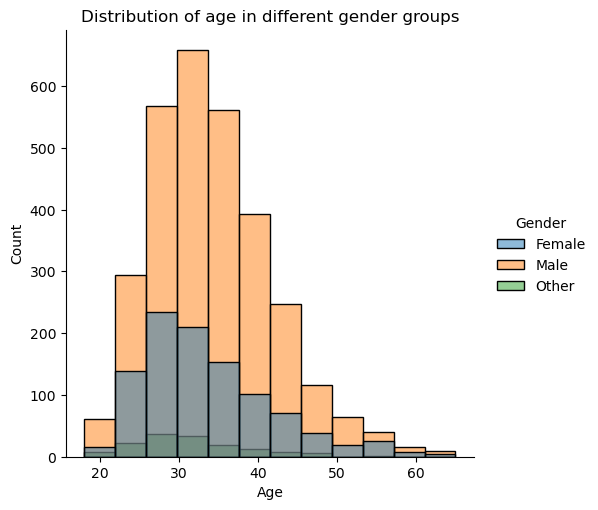

In [28]:
sns.displot(demog, x="Age",  hue="Gender", bins=12)

plt.title("Distribution of age in different gender groups")

plt.show()

In [29]:
demog["Age"].describe().round(1)

count    4195.0
mean       33.8
std         7.9
min        18.0
25%        28.0
50%        33.0
75%        38.0
max        65.0
Name: Age, dtype: float64

In [30]:
print(((demog["Gender"] == "Female").sum()/len(demog))*100)
print(((demog["Gender"] == "Male").sum()/len(demog))*100)

24.29082240762813
72.22884386174016


**In total 4195 respondents, ages 18 to 65, took part in the surveys. Majority of them were male (72 %), females comprised 24 % of respondents. Average age was 34, standard deviation 8 years. Females in Tech/IT seem to be slightly younger than their male colleagues, but the difference is very small.**

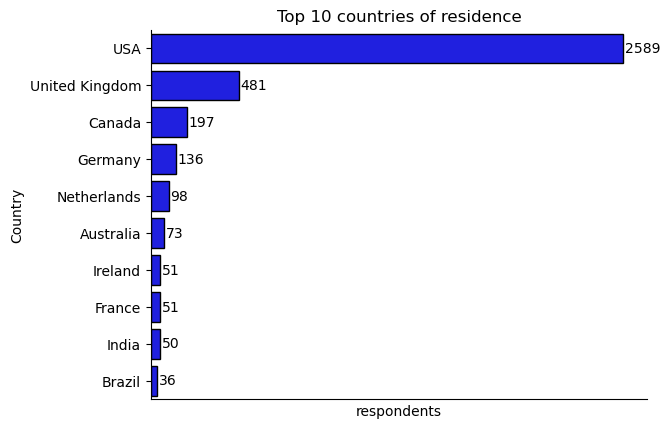

In [31]:
countries = (
    demog.groupby("Country")
    .size().reset_index(name="respondents")
    .sort_values(by="respondents", ascending=False)
)
countries = countries.head(10)

ax = sns.barplot(y="Country", x="respondents", data=countries,
            edgecolor="black", color="blue")
for i, v in enumerate(countries['respondents']):
    ax.text(v + 10, i, str(v), ha='left', va='center')
ax.set_xticks([])
sns.despine()
plt.ylabel("Country")
plt.title("Top 10 countries of residence")

plt.show()

In [32]:
print((countries[countries['Country'] == 'USA']['respondents'].values[0])/len(demog)*100)
print((countries[countries['Country'] == 'United Kingdom']['respondents'].values[0])/len(demog)*100)
print((countries[countries['Country'] == 'Canada']['respondents'].values[0])/len(demog)*100)

61.71632896305125
11.466030989272943
4.69606674612634


**Majority of respondents (62 %) live in USA. Second and third most represented countries are UK and Canada, with 11 % and 5 % of respondents, respectively.**

## Analysis of mental health

### How many respondents suffer from mental health related issues?

In [33]:
query = """
    WITH mental AS
    (
    SELECT UserID,
            MAX(CASE WHEN (QuestionID = 32 AND AnswerText != -1) THEN AnswerText END) AS Past_illness,
            MAX(CASE WHEN (QuestionID = 33 AND AnswerText != -1) THEN AnswerText END) AS Current_illness,
            MAX(CASE WHEN (QuestionID = 78 AND AnswerText = 0) THEN 'No'
                     WHEN (QuestionID = 78 AND AnswerText = 1) THEN 'Yes' END) AS Open_at_work,
            MAX(CASE WHEN (QuestionID = 2 AND AnswerText IN ('Male', 'male')) THEN 'Male'
                     WHEN (QuestionID = 2 AND AnswerText IN ('Female', 'female')) THEN 'Female' END) AS Gender
        FROM FiltAnswer
        GROUP BY UserID
    ) 
    SELECT
        Past_illness,
        Current_illness,
        Open_at_work,
        Gender,
        COUNT(UserID) * 100.0 / (SELECT COUNT(DISTINCT UserID) FROM mental) AS Respondents
    FROM mental
    GROUP BY Past_illness, Current_illness, Open_at_work, Gender
    """
mental = pd.read_sql(query, con)

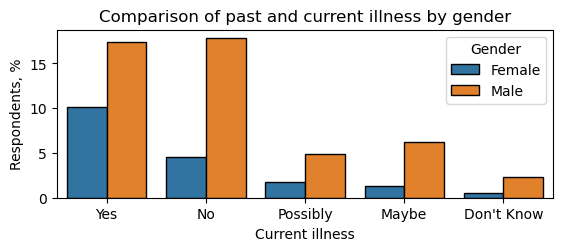

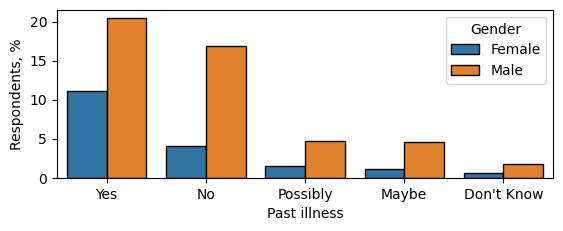

In [34]:
order = ["Yes", "No", "Possibly", "Maybe", "Don't Know"]
plt.subplot(2, 1, 1)
sns.barplot(x="Current_illness", y="Respondents", data=mental,
            edgecolor="black", estimator=sum, order=order,
            errorbar=None, hue = "Gender"
           )
plt.xlabel("Current illness")
plt.ylabel("Respondents, %")
plt.title("Comparison of past and current illness by gender")
plt.show()

plt.subplot(2, 1, 2)
sns.barplot(x="Past_illness", y="Respondents", data=mental,
            edgecolor="black", estimator=sum, order=order,
            errorbar=None, hue = "Gender"
           )
plt.xlabel("Past illness")
plt.ylabel("Respondents, %")
plt.show()

**Out of total respondents, approximately the same percentage of males are currently mentally ill as those who are not. Nearly twice as many females answered that they are ill compared to those that answered 'No'. In the past, more males answered that they are ill than not ill. In general, seems like in the Tech/IT, more people are or have been mentally ill or think they could be ill than those who are not and were not ill in the past.**

In [35]:
query = """
    WITH mental AS
    (
    SELECT UserID,
            MAX(CASE WHEN (QuestionID = 32 AND AnswerText != -1) THEN AnswerText END) AS Past_illness,
            MAX(CASE WHEN (QuestionID = 33 AND AnswerText != -1) THEN AnswerText END) AS Current_illness,
            MAX(CASE WHEN (QuestionID = 78 AND AnswerText = 0) THEN 'No'
                     WHEN (QuestionID = 78 AND AnswerText = 1) THEN 'Yes' END) AS Open_at_work,
            MAX(CASE WHEN (QuestionID = 2 AND AnswerText IN ('Male', 'male')) THEN 'Male'
                     WHEN (QuestionID = 2 AND AnswerText IN ('Female', 'female')) THEN 'Female' END) AS Gender
        FROM FiltAnswer
        GROUP BY UserID
    ) 
    SELECT        
        Open_at_work,
        Gender,
        COUNT(UserID) * 100.0 / (SELECT COUNT(DISTINCT UserID) FROM mental) AS Respondents
    FROM mental
    WHERE Past_illness = 'Yes' OR Current_illness = 'Yes'
    GROUP BY  Open_at_work, Gender
    """
mentalopen = pd.read_sql(query, con)


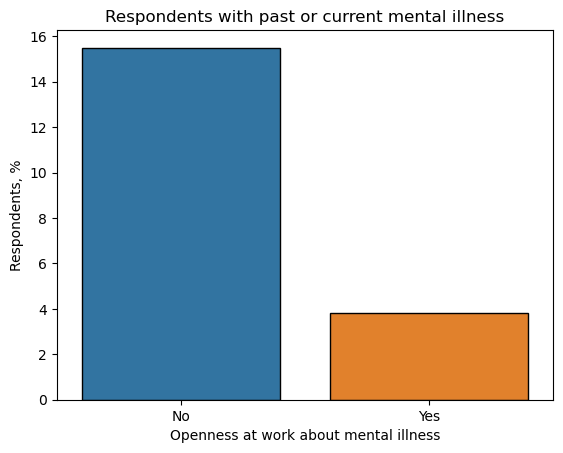

In [36]:
sns.barplot(x="Open_at_work", y="Respondents", data=mentalopen,
            edgecolor="black", estimator=sum,
            errorbar=None
           )
plt.xlabel("Openness at work about mental illness")
plt.ylabel("Respondents, %")
plt.title("Respondents with past or current mental illness")
plt.show()

**Out of those who have past or present mental illness, only about 4 % chose to be open about it. Nearly 16 % are not open, and the rest did not want to answer this question at all.**<br>

*Do those respondents who have a mental health condition feel like it interferes with their work? And is there a difference if work is in office or remotely?*<br>
*Questions 92 and 93<br>
If you have a mental health condition, do you feel that it interferes with your work?<br>
Do you work remotely at least 50% of the time?*

In [37]:
query = """
WITH RemoteWork AS (
    SELECT AnswerText AS remote_work, UserID
    FROM FiltAnswer
    WHERE QuestionID = 92 AND AnswerText != '-1'
),
InterferenceWithWork AS (
    SELECT AnswerText AS interferes_with_work, UserID
    FROM FiltAnswer
    WHERE QuestionID = 93 AND AnswerText != '-1'
)
SELECT rw.remote_work, iww.interferes_with_work
FROM RemoteWork rw
JOIN InterferenceWithWork iww
ON rw.UserID = iww.UserID
"""
remote = pd.read_sql(query, con)

In [38]:
pd.crosstab(remote['remote_work'], remote['interferes_with_work'], margins=True, margins_name="Total")

interferes_with_work,No,Yes,Total
remote_work,,,
Never,157,54,211
Often,92,48,140
Rarely,119,54,173
Sometimes,322,143,465
Total,690,299,989


In [39]:
table = pd.crosstab(remote['remote_work'], remote['interferes_with_work'])
chi2, p, dof, expected = chi2_contingency(table)
print("Chi-squared statistics:", chi2, "p-value:", p)

Chi-squared statistics: 3.3828860652704904 p-value: 0.3362720500922192


In [40]:
(table['No'].sum()/table.sum().sum()*100).round()

70.0

**There is no significant association between remote work and interference with work, which suggest that alowing employees work remotely more often would not affect their work performance. It seems like respondents deal with their mental health issues pretty well, based on the fact that 70% said that it does not interfere with their work.**

### Do respondents feel safe to discuss their mental health problems with their supervisors and co-workers?
List of question that will help to answer:
- Has your employer ever formally discussed mental health 15
- Would you feel comfortable discussing a mental health issue with your coworkers 18
- Would you feel comfortable discussing a mental health issue with your direct supervisor(s) 19
- Would you bring up a mental health issue with a potential employer in an interview? 12
- Have you ever discussed your mental health with your employer? 58
- Have your ever discussed your mental health with coworkers? 60
- If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts? 52
- If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees? 53
- Overall, how much importance does your employer place on mental health? 65

*The "would you" table*

In [6]:
query = """
    WITH would AS
    (
    SELECT UserID,
        MAX(CASE WHEN (QuestionID = 18 AND AnswerText != -1) THEN AnswerText END) AS coworker,
        MAX(CASE WHEN (QuestionID = 19 AND AnswerText != -1) THEN AnswerText END) AS supervisor,
        MAX(CASE WHEN (QuestionID = 12 AND AnswerText != -1) THEN AnswerText END) AS pot_employer,
        MAX(CASE WHEN (QuestionID = 15 AND AnswerText != -1) THEN AnswerText END) AS emp_discussed,
        MAX(CASE WHEN (QuestionID = 65 AND AnswerText != -1) THEN AnswerText END) AS emp_importance
    FROM FiltAnswer
    GROUP BY UserID
    )
    SELECT
        coworker,
        supervisor,
        pot_employer,
        emp_discussed,
        emp_importance,
        COUNT(UserID)  AS Respondents
    FROM would
    GROUP BY coworker, supervisor, pot_employer, emp_discussed, emp_importance
    """
would = pd.read_sql(query, con)        

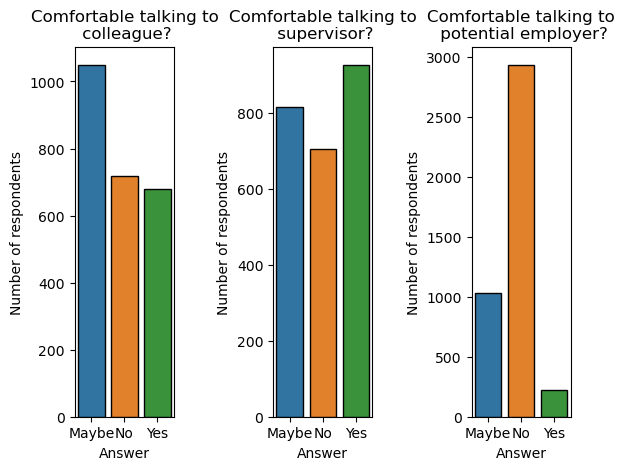

In [42]:
plt.subplot(1, 3, 1)
sns.barplot(x="coworker", y="Respondents",
            data=would, edgecolor="black",
            estimator=sum, errorbar=None)
plt.xlabel("Answer")
plt.ylabel("Number of respondents")
plt.title("Comfortable talking to\n colleague?")

plt.subplot(1,3,2)
sns.barplot(x="supervisor", y="Respondents",
            data=would, edgecolor="black",
            estimator=sum, errorbar=None)
plt.xlabel("Answer")
plt.ylabel("Number of respondents")
plt.title("Comfortable talking to\n supervisor?")

plt.subplot(1, 3, 3)
sns.barplot(x="pot_employer", y="Respondents",
            data=would, edgecolor="black",
            estimator=sum, errorbar=None)
plt.xlabel("Answer")
plt.ylabel("Number of respondents")
plt.title("Comfortable talking to\n potential employer?")

plt.subplots_adjust(wspace=1)

plt.show()


**Respondents feel more comfortable talking to their supervisors about their mental health issues than to their colleagues. Overall more respondents would feel comfortable or at least maybe feel comfortable talking to their colleagues or supervisors than those who would not feel comfortable. Situation changed drastically when respondents were asked about talking to potential employer. Nearly 3000 answered 'no', only about 200 answered 'yes' and about 1000 answered 'maybe'**

*Does it have any effect if the employer ever discussed mental health with employees or not?*

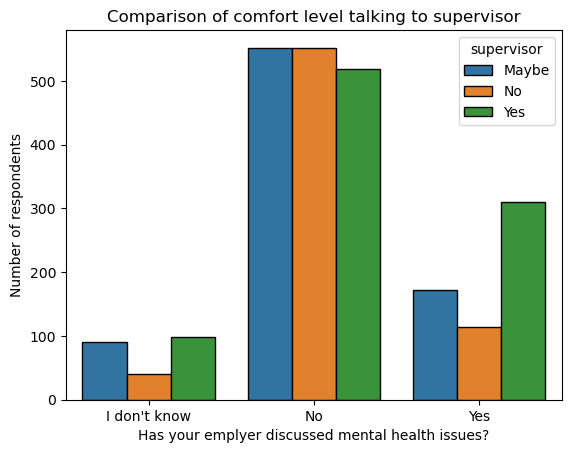

In [43]:
sns.barplot(x="emp_discussed", y="Respondents",
            data=would, edgecolor="black",
            estimator=sum, errorbar=None, hue="supervisor")
plt.xlabel("Has your emplyer discussed mental health issues?")
plt.ylabel("Number of respondents")
plt.title("Comparison of comfort level talking to supervisor")
plt.show()

**In the group of respondents that were given a talk about mental health from their empoyer, more were comfortable talking about their mental issues with supervisor. This indicates that employees may feel more comfortable talking about their mental health issues if employers talk about it.**

*How do respondents overall evaluate importabce of mental health to their employers?*

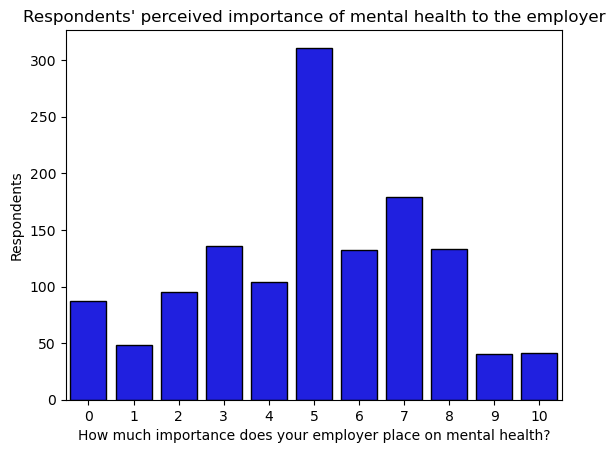

In [44]:
order= ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
sns.barplot(x="emp_importance", y="Respondents", data=would,
           estimator=sum, errorbar=None, order=order,
            edgecolor="black", color="blue")
plt.xlabel("How much importance does your employer place on mental health?")
plt.title("Respondents' perceived importance of mental health to the employer")
plt.show()

**The number of respondents who think mental health issues are important to their employer (rated 9 to 10) is much lower than those who think it is not important at all (rated 0 to 1).**

*The "Have you" table*<br>
*Questions:*<br>
*Have you ever discussed your mental health with your employer?* <br>
*Have your ever discussed your mental health with coworkers?*

In [45]:
query = """
    WITH have AS
    (
    SELECT UserID,
        MAX(CASE WHEN (QuestionID = 58 AND AnswerText = 0) THEN 'No'
            WHEN (QuestionID = 58 AND AnswerText = 1) THEN 'Yes' END) AS employer,
        MAX(CASE WHEN (QuestionID = 60 AND AnswerText = 0) THEN 'No'
            WHEN (QuestionID = 58 AND AnswerText = 1) THEN 'Yes' END) AS coworker        
    FROM FiltAnswer
    GROUP BY UserID
    )
    SELECT
        employer,
        coworker,        
        COUNT(UserID)  AS Respondents
    FROM have
    GROUP BY coworker, employer
    """
have = pd.read_sql(query, con)        

*Have respondents talked to their colleagues or employers about their mental health?*

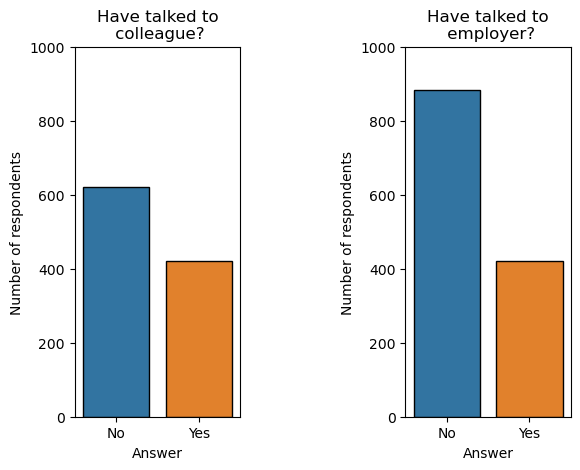

In [46]:
plt.subplot(1, 2, 1)
sns.barplot(x="coworker", y="Respondents",
            data=have, edgecolor="black",
            estimator=sum, errorbar=None)
plt.xlabel("Answer")
plt.ylabel("Number of respondents")
plt.title("Have talked to\n colleague?")
plt.ylim(0, 1000)

plt.subplot(1,2,2)
sns.barplot(x="employer", y="Respondents",
            data=have, edgecolor="black",
            estimator=sum, errorbar=None)
plt.xlabel("Answer")
plt.ylabel("Number of respondents")
plt.title("Have talked to\n employer?")
plt.ylim(0, 1000)

plt.subplots_adjust(wspace=1)

plt.show()

**Even though based on the previous figure, respondents would be more comfortable discussing their mental health with supervisors than with colleagues, about the same number have actually talked to  colleague or to employer.** 

*The 'reveal' table*<br>
*If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?<br>
If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?*

In [47]:
query = """
    WITH reveal AS
    (
    SELECT UserID,
        MAX(CASE WHEN (QuestionID = 52 AND AnswerText != -1) THEN AnswerText END) AS client,            
        MAX(CASE WHEN (QuestionID = 53 AND AnswerText != -1) THEN AnswerText END) AS coworker            
    FROM FiltAnswer
    GROUP BY UserID
    )
    SELECT
        client,
        coworker,        
        COUNT(UserID)  AS Respondents
    FROM reveal
    GROUP BY coworker, client
    """
reveal = pd.read_sql(query, con)        

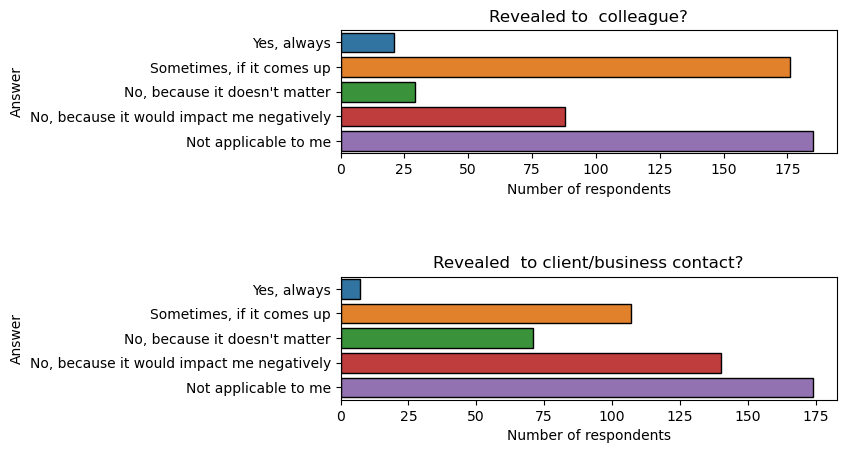

In [48]:
order = ["Yes, always",
         "Sometimes, if it comes up",
         "No, because it doesn't matter",
         "No, because it would impact me negatively",
         "Not applicable to me"]
plt.subplot(2, 1, 1)
sns.barplot(y="coworker", x="Respondents",
            data=reveal, edgecolor="black",
            estimator=sum, errorbar=None, order=order)
plt.ylabel("Answer")
plt.xlabel("Number of respondents")
plt.title("Revealed to  colleague?")

plt.subplot(2,1,2)
sns.barplot(y="client", x="Respondents",
            data=reveal, edgecolor="black",
            estimator=sum, errorbar=None, order=order)
plt.ylabel("Answer")
plt.xlabel("Number of respondents")
plt.title("Revealed  to client/business contact?")

plt.subplots_adjust(hspace=1)

plt.show()

**Respondents who were diagnosed with mental illness, did not willingly reveal to their colleagues or clients/business contacts about it. More were willing to reveal it if the topic of mental illness came up in conversation. In general, respondents were much more cautious when talking to their clients/business partners and did not reveal their mental illness, either because theu believed it was not important or because they feared negative consequences.**

### Do respondents face/fear to face negative consequences to their career if their mental health status is disclosed to their clients/business contacts/employers?
List of questions that will help to answer:
- If you have revealed a mental health disorder to a client or business contact, how has this affected you or the relationship? 66
- If you have revealed a mental health disorder to a coworker or emploee contact, how has this affected you or the relationship? 67
- Do you think that discussing a mental health issue with your employer would have negative consequences? 98
- Do you feel that being identified as a person with a mental health issue would hurt your career? 113
- Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue? 114
- Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace? 56

*The 'ifyou' table*

In [49]:
query = """
    WITH ifyou AS
    (
    SELECT UserID,
        MAX(CASE WHEN (QuestionID = 66 AND AnswerText != -1) THEN AnswerText END) AS client,            
        MAX(CASE WHEN (QuestionID = 67 AND AnswerText != -1) THEN AnswerText END) AS coworker            
    FROM FiltAnswer
    GROUP BY UserID
    )
    SELECT
        client,
        coworker,        
        COUNT(UserID)  AS Respondents
    FROM ifyou
    GROUP BY coworker, client
    """
ifyou = pd.read_sql(query, con)    

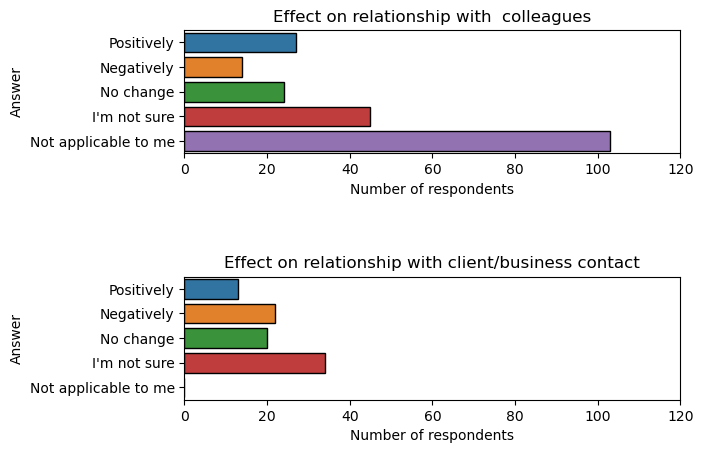

In [50]:
order = ["Positively",
         "Negatively",
         "No change",
         "I'm not sure",
         "Not applicable to me"]
plt.subplot(2, 1, 1)
sns.barplot(y="coworker", x="Respondents",
            data=ifyou, edgecolor="black",
            estimator=sum, errorbar=None, order=order)
plt.ylabel("Answer")
plt.xlabel("Number of respondents")
plt.title("Effect on relationship with  colleagues")
plt.xlim(0, 120)

plt.subplot(2,1,2)
sns.barplot(y="client", x="Respondents",
            data=ifyou, edgecolor="black",
            estimator=sum, errorbar=None, order=order)
plt.ylabel("Answer")
plt.xlabel("Number of respondents")
plt.title("Effect on relationship with client/business contact")
plt.xlim(0, 120)

plt.subplots_adjust(hspace=1)

plt.show()

**Revealing to a colleague about the mental health disorder ended up in positive outcome or no change more often than in negative outcome.The effect was different with client/business contact group. There were more negative outcomes than positive or no change. Previous analysis showed that a lot of respondents thought that revealing information about their mental disorders will affect their relationship with clients/business partners negatively. Possibly, this fear was based on experience. It would be interesting to look at it deeper and see if there realy is some corelation, but the number of respondents who answered the questions is very low.**

*The 'doyou' table*<br>
*Do you think that discussing a mental health issue with your employer would have negative consequences?
Do you feel that being identified as a person with a mental health issue would hurt your career?
Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?
Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?*

In [51]:
query = """
    WITH doyou AS
    (
    SELECT UserID,
        MAX(CASE WHEN (QuestionID = 98 AND AnswerText != -1) THEN AnswerText END) AS employer,            
        MAX(CASE WHEN (QuestionID = 113 AND AnswerText != -1) THEN AnswerText END) AS career,
        MAX(CASE WHEN (QuestionID = 114 AND AnswerText != -1) THEN AnswerText END) AS coworker,
        MAX(CASE WHEN (QuestionID = 56 AND AnswerText != -1) THEN AnswerText END) AS badres
    FROM FiltAnswer
    GROUP BY UserID
    )
    SELECT
        employer,
        career,
        coworker,
        badres,
        COUNT(UserID)  AS Respondents
    FROM doyou
    GROUP BY employer, career, coworker, badres
    """
doyou = pd.read_sql(query, con)   

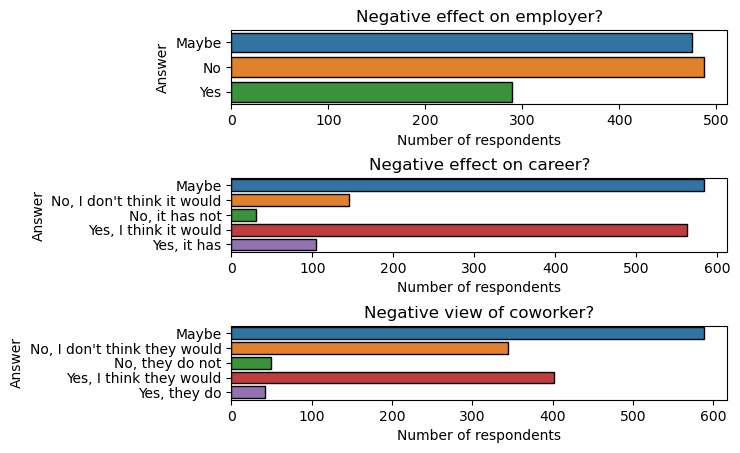

In [52]:
plt.subplot(3, 1, 1)
sns.barplot(y="employer", x="Respondents",
            data=doyou, edgecolor="black",
            estimator=sum, errorbar=None)
plt.ylabel("Answer")
plt.xlabel("Number of respondents")
plt.title("Negative effect on employer?")

plt.subplot(3,1,2)
sns.barplot(y="career", x="Respondents",
            data=doyou, edgecolor="black",
            estimator=sum, errorbar=None)
plt.ylabel("Answer")
plt.xlabel("Number of respondents")
plt.title("Negative effect on career?")

plt.subplot(3, 1, 3)
sns.barplot(y="coworker", x="Respondents",
            data=doyou, edgecolor="black",
            estimator=sum, errorbar=None)
plt.ylabel("Answer")
plt.xlabel("Number of respondents")
plt.title("Negative view of coworker?")

plt.subplots_adjust(hspace=1)

plt.show()

**More respondents think revealing their mental health issues to the employer would not have negative consequences than that it would. Paradoxically, more respondents think that being identified as a person with a mental health issue would hurt their career compared to those that think it would not. Maybe it is related to previously highlighted fear to disclose mental health issues to clients or possible future employers, even though respondents in general seem to feel quite comfortable with their current employer. More respondents think that their colleagues would view them negativelly if mental health issues were disclosed compared to those who do not think so. However, biggest group of respondents are unsure (answered 'maybe').**

*Is there any relation between fear of negative effect on career and observed or experienced an unsupportive or badly handled response to a mental health issue in the place of work?*

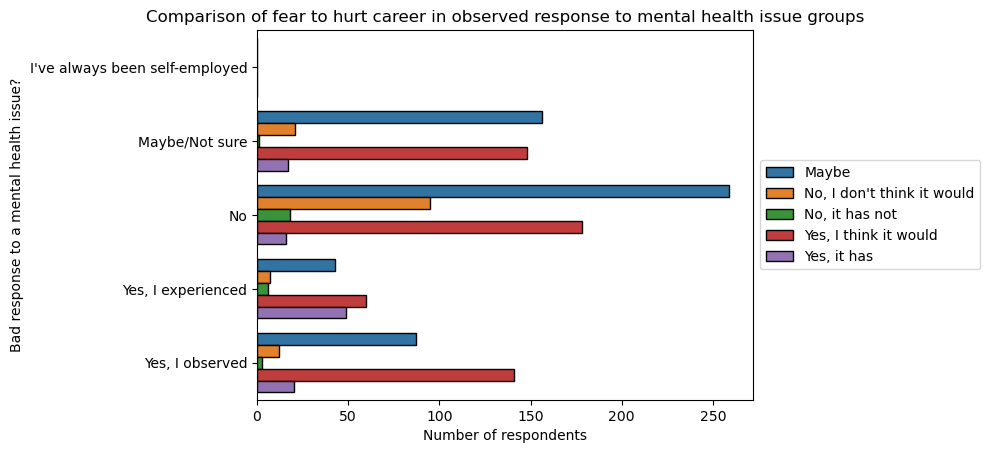

In [53]:
sns.barplot(y="badres", x="Respondents",
            data=doyou, edgecolor="black",
            estimator=sum, errorbar=None, hue="career")
plt.ylabel("Bad response to a mental health issue?")
plt.xlabel("Number of respondents")
plt.title("Comparison of fear to hurt career in observed response to mental health issue groups")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

In [56]:
badres_counts = doyou.groupby("badres")["Respondents"].sum().reset_index()
print(badres_counts)
print((
    badres_counts.loc[badres_counts["badres"] == "No", "Respondents"]
    .values[0]/badres_counts["Respondents"].sum()*100).round()
)

                           badres  Respondents
0  I've always been self-employed           15
1                  Maybe/Not sure          745
2                              No         1205
3              Yes, I experienced          352
4                 Yes, I observed          539
42.0


**Respondents who have experienced or observed bad response to mental health issues were more convinced that revealing their own mental health issues will hurt their career. However more respondents did not observe any badly handled mental health related situation (1205, 42% of total respondents) than those who observed (539) or even experienced it (352).**

## CONCLUSIONS
- In total 4195 respondents, ages 18 to 65, took part in the surveys. Tech/IT industry is dominated by males (72 %), females comprised 24 % of respondents. Average age of respondents was 34, standard deviation 8 years. Majority of respondents (62 %) live in USA.
- More respondents are or have been mentally ill or think they could be ill than those who are not and were not ill in the past.
- More respondents would feel comfortable or at least maybe feel comfortable talking to their colleagues or supervisors than those who would not feel comfortable. However majority would not feel comfortable discussing it with potential employers.
- respondents feel more comfortable talking about their mental health issues with direct supervisors if employers formally discuss meant health at their work place.
- respondents were much more cautious when talking to their clients/business partners compared to talking to colleague and did not reveal their mental illness, either because they believed it was not important or because they feared negative consequences.
- revealing to a colleague about the mental health disorder ended up in positive outcome or no change more often than in negative outcome. There were more negative outcomes than positive or no change after revealing mental health issue to client/business contact.
- more respondents think that being identified as a person with a mental health issue would hurt their career compared to those that think it would not.
- more respondents did not observe any badly handled mental health related situation than those who observed  or even experienced it